In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *

In [4]:
batch_size = 64

In [5]:
data_path = "data/cactus/"
data_path_train = data_path + "train/"
data_path_test = data_path + "test/"

In [6]:
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "sample_submission.csv")

In [7]:
df_train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [8]:
data = ImageDataBunch.from_df(data_path_train, df_train, ds_tfms=get_transforms(), bs=batch_size).normalize(imagenet_stats)

In [9]:
data.add_test(ImageList.from_df(df_test, path=data_path_test))

In [10]:
data

ImageDataBunch;

Train: LabelList (14000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
1,1,1,1,0
Path: data/cactus/train;

Valid: LabelList (3500 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
0,1,1,1,0
Path: data/cactus/train;

Test: LabelList (4000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: EmptyLabelList
,,,,
Path: data/cactus/train

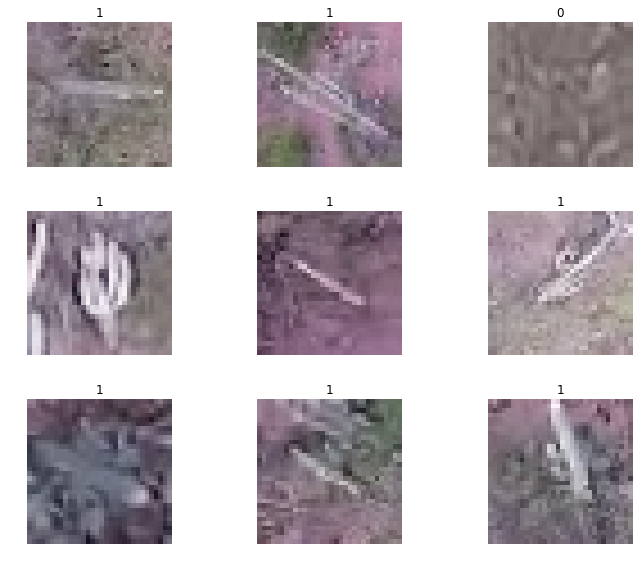

In [11]:
data.show_batch(rows = 3, figsize = (10,8))

In [12]:
print(data.classes)

[0, 1]


In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.226629,0.188914,0.074000,00:07
1,0.139017,0.092534,0.035714,00:07
2,0.103106,0.071507,0.027143,00:06
3,0.085316,0.074305,0.027714,00:07


In [16]:
learn.save('stage-1')

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

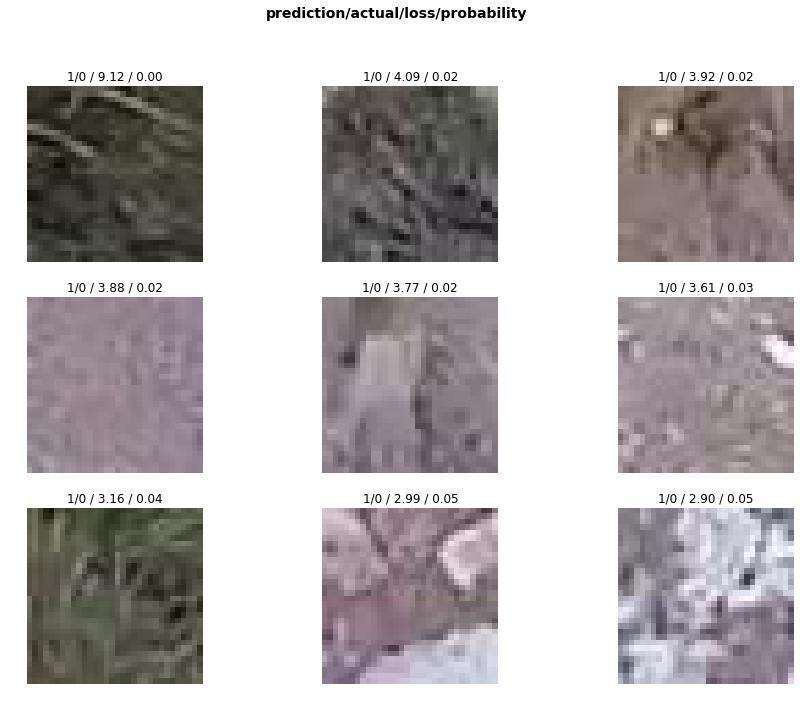

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

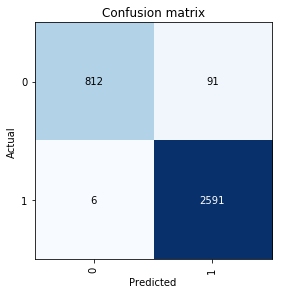

In [19]:
interp.plot_confusion_matrix()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


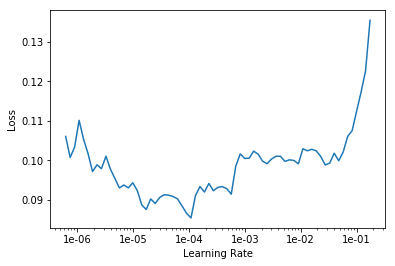

In [23]:
learn.recorder.plot()

In [24]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.080607,0.049479,0.016571,00:08
1,0.069249,0.045780,0.015714,00:08


In [25]:
interp = ClassificationInterpretation.from_learner(learn)

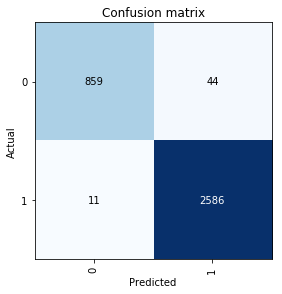

In [26]:
interp.plot_confusion_matrix()

### Predictions

In [59]:
predictions = learn.get_preds(ds_type=DatasetType.Test)[0]

In [60]:
predictions[0]

tensor([0.0208, 0.9792])

In [63]:
predictions[:10]

tensor([[2.0845e-02, 9.7915e-01],
        [2.5046e-04, 9.9975e-01],
        [9.7412e-01, 2.5884e-02],
        [9.9648e-01, 3.5206e-03],
        [1.5973e-04, 9.9984e-01],
        [4.9532e-03, 9.9505e-01],
        [7.4776e-04, 9.9925e-01],
        [5.7240e-03, 9.9428e-01],
        [4.8432e-03, 9.9516e-01],
        [9.5441e-01, 4.5595e-02]])

In [64]:
predicted_classes = np.argmax(predictions, axis=1)

In [65]:
predicted_classes[:10]

tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 0])

In [67]:
df_test['has_cactus'] = predicted_classes
df_test.head(10)

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1
1,0017242f54ececa4512b4d7937d1e21e.jpg,1
2,001ee6d8564003107853118ab87df407.jpg,0
3,002e175c3c1e060769475f52182583d0.jpg,0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1
5,0038ed6f7417b8275b393307f66cb1e3.jpg,1
6,0059dfa41de4441fc23b9a4b98ba99cb.jpg,1
7,0061bd302d735db829418cb90b4e6040.jpg,1
8,00754573d8c7223e73da553dd43780bd.jpg,1
9,008d9fce71c8e03a4c9cdd15ea908573.jpg,0


### Create Submission File

In [76]:
from datetime import datetime
time_format = "%Y%m%d-%H%M%S.%f"
time_stamp = datetime.now().strftime(time_format)
file_path = "{0}submission_{1}.csv".format(data_path, datetime.now().strftime(time_format))
                                        
print("Exporting Submission file with {0} rows at {1}".format(df_test.shape[0], file_path))

df_test.to_csv(file_path, index = False)

Exporting Submission file with 4000 rows at data/cactus/submission_20190529-192100.737993.csv
